# Слайды по CNN
http://introtodeeplearning.com/slides/6S191_MIT_DeepLearning_L3.pdf

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [1]:
#1
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # x -> (x-mean)/std, преобразует  [0,1] -> [-1,1]

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./cifar10data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10data/cifar-10-python.tar.gz to ./cifar10data
Files already downloaded and verified


frog  cat   ship  plane truck truck deer  bird  truck bird  plane cat   truck frog  dog   car  


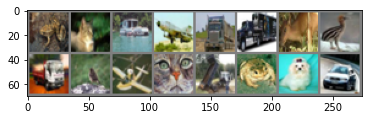

In [2]:
#2
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [3]:
#3
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, dbg=False):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dbg = dbg

    def forward(self, x):
        if self.dbg:
            insize = x.size()            
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        if self.dbg:
            outsize = x.size()
            print("\tIn Model: input size", insize, "output size", outsize)
        return x

In [6]:
#4
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

PATH = './cifar_net.pth'
print(net.conv1.weight.shape)
print(net.conv1.bias.shape)

torch.Size([6, 3, 5, 5])
torch.Size([6])


In [7]:
#5
#Не запускайте во время занятия, долгая тренировка на CPU
import time
start = time.time()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

finish = time.time()
print('Finished Training in ', finish-start)
torch.save(net.state_dict(), PATH)

[1,  1000] loss: 1.138
[1,  2000] loss: 1.017
[1,  3000] loss: 0.929
[2,  1000] loss: 0.841
[2,  2000] loss: 0.795
[2,  3000] loss: 0.767
Finished Training in  28.088237285614014


GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


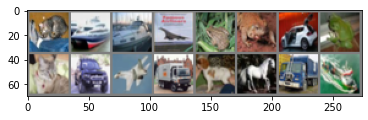

In [8]:
#6
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
#7
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
#8
outputs = net(images)
outputs[0:2]

tensor([[-1.0358, -2.3505,  0.7104,  2.2274, -0.6118,  1.6966,  0.3156, -0.1435,
         -0.7089, -0.9091],
        [ 2.7844,  3.1373, -0.9268, -2.2093, -1.5672, -3.4862, -3.4537, -3.1817,
          3.8209,  2.8421]], grad_fn=<SliceBackward0>)

In [13]:
#9
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  cat   ship  car   ship  cat   frog  truck deer  dog   car   plane truck dog   horse truck truck


In [14]:
#10
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 46 %


In [15]:
#11
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 53.9 %
Accuracy for class: car   is 54.4 %
Accuracy for class: bird  is 21.7 %
Accuracy for class: cat   is 27.1 %
Accuracy for class: deer  is 32.1 %
Accuracy for class: dog   is 50.1 %
Accuracy for class: frog  is 42.5 %
Accuracy for class: horse is 62.3 %
Accuracy for class: ship  is 58.9 %
Accuracy for class: truck is 63.6 %


# Тренировка на GPU

In [16]:
#12
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:2


In [17]:
#13
netGPU = Net()
netGPU.to(device)

criterion = nn.CrossEntropyLoss()
optimizerGPU = optim.SGD(netGPU.parameters(), lr=0.001, momentum=0.9)

In [18]:
#14
import time
start = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizerGPU.zero_grad()

        # forward + backward + optimize
        outputs = netGPU(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizerGPU.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

finish = time.time()
print('Finished Training in ', finish-start)

[1,  1000] loss: 1.139
[1,  2000] loss: 1.005
[1,  3000] loss: 0.925
[2,  1000] loss: 0.834
[2,  2000] loss: 0.778
[2,  3000] loss: 0.745
Finished Training in  57.61101984977722


In [20]:
#15
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = netGPU(images).cpu()
outputs[0:1]

tensor([[-1.0035, -1.8962,  1.1109,  2.3791, -0.4076,  1.5623,  0.4591, -0.9544,
          0.0104, -0.7836]], grad_fn=<SliceBackward0>)

In [21]:
#16
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(8)))

Predicted:  cat   car   car   ship  frog  frog  car   frog 


In [22]:
#17
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = netGPU(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 49 %


# Multi-GPU

In [23]:
#18
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
netMultiGPU = Net(True)
netMultiGPU = nn.DataParallel(netMultiGPU)
netMultiGPU.to(device)

DataParallel(
  (module): Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [24]:
#19
for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = netMultiGPU(inputs)
    print("Outside: input size", inputs.size(),
          "output_size", outputs.size())
    break

	In Model: input size torch.Size([4, 3, 32, 32]) output size torch.Size([4, 10])
	In Model: input size torch.Size([4, 3, 32, 32]) output size torch.Size([4, 10])
	In Model: input size torch.Size([4, 3, 32, 32]) output size torch.Size([4, 10])
	In Model: input size torch.Size([4, 3, 32, 32]) output size torch.Size([4, 10])
Outside: input size torch.Size([16, 3, 32, 32]) output_size torch.Size([16, 10])


In [25]:
#20
netMultiGPU = Net(False)
netMultiGPU = nn.DataParallel(netMultiGPU)
netMultiGPU.to(device)

criterion = nn.CrossEntropyLoss()
optimizerMultiGPU = optim.SGD(netMultiGPU.parameters(), lr=0.001, momentum=0.9)

In [26]:
#21
import time
start = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizerMultiGPU.zero_grad()

        # forward + backward + optimize
        outputs = netMultiGPU(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizerMultiGPU.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

finish = time.time()
print('Finished Training in ', finish-start)

[1,  1000] loss: 1.149
[1,  2000] loss: 1.048
[1,  3000] loss: 0.918
[2,  1000] loss: 0.838
[2,  2000] loss: 0.786
[2,  3000] loss: 0.742
Finished Training in  101.61219501495361


In [27]:
#22
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = netMultiGPU(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 48 %
